# History aware retriever for chatting with documents

In [ ]:
import os
from dotenv import load_dotenv

# text splitters
from langchain_text_splitters import RecursiveCharacterTextSplitter

from langchain_core.prompts import ChatPromptTemplate
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser

from langchain.chains import create_history_aware_retriever
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.prompts import MessagesPlaceholder
from langchain_chroma import Chroma # ChromaDB vector store

In [3]:
# Loading api keys
load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")
# google_api_key = os.getenv("GOOGLE_API_KEY")

# Splitting into chunks

In [4]:
splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n", " ", ""],
    chunk_size=1000, # for production, use 1000 or more
    chunk_overlap=50, # for production, use 50 or more
)

# Embedding the chunks

In [5]:
from langchain_openai import OpenAIEmbeddings

embedding_model = OpenAIEmbeddings(
    model="text-embedding-3-small",  # Use a smaller model for faster processing
    openai_api_key=openai_api_key,
)

## accessing/querying the vector database
Once your vector store has been created and the relevant documents have been added you will most likely wish to query it during the running of your chain or agent.

In [6]:
persist_dir = "./vector_store"  # Directory to save the vector store

In [7]:
vector_store_pers = Chroma(
    collection_name="book-rag",  # Name of the collection in the vector store
    embedding_function=embedding_model,
    persist_directory=persist_dir,  # Directory to save the vector store
)

# LLM

In [10]:
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.0,  # Set temperature to 0 for deterministic output
    openai_api_key=openai_api_key,
)

# Instantiating a retriever

In [8]:
retriever = vector_store_pers.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 2}  # Retrieve the top 2 most similar documents
)

# RAG-Chain

In [ ]:
# Create a prompt for contextualizing questions based on chat history
contextualize_q_system_prompt = """Given a chat history and the latest user question \
which might reference context in the chat history, formulate a standalone question \
which can be understood without the chat history. Do NOT answer the question, \
just reformulate it if needed and otherwise return it as is."""

contextualize_q_prompt = ChatPromptTemplate.from_messages([
    ("system", contextualize_q_system_prompt),
    MessagesPlaceholder("chat_history"),
    ("human", "{input}"),
])

# Create history-aware retriever
history_aware_retriever = create_history_aware_retriever(
    llm, retriever, contextualize_q_prompt
)

# Create the main RAG prompt that includes chat history
qa_system_prompt = """You are an assistant for question-answering tasks. \
Use the following pieces of retrieved context to answer the question. \
If you don't know the answer, just say that you don't know. \
Use three sentences maximum and keep the answer concise.

Context: {context}"""

qa_prompt = ChatPromptTemplate.from_messages([
    ("system", qa_system_prompt),
    MessagesPlaceholder("chat_history"),
    ("human", "{input}"),
])

question_answer_chain = create_stuff_documents_chain(llm, qa_prompt) # qa_prompt | llm

# Create the question-answer chain
rag_chain = create_retrieval_chain(history_aware_retriever, question_answer_chain)

In [12]:
rag_chain

RunnableBinding(bound=RunnableAssign(mapper={
  context: RunnableBinding(bound=RunnableBranch(branches=[(RunnableLambda(lambda x: not x.get('chat_history', False)), RunnableLambda(lambda x: x['input'])
           | VectorStoreRetriever(tags=['Chroma', 'OpenAIEmbeddings'], vectorstore=<langchain_chroma.vectorstores.Chroma object at 0x000001CA4EABEBA0>, search_kwargs={'k': 2}))], default=ChatPromptTemplate(input_variables=['chat_history', 'input'], input_types={'chat_history': list[typing.Annotated[typing.Union[typing.Annotated[langchain_core.messages.ai.AIMessage, Tag(tag='ai')], typing.Annotated[langchain_core.messages.human.HumanMessage, Tag(tag='human')], typing.Annotated[langchain_core.messages.chat.ChatMessage, Tag(tag='chat')], typing.Annotated[langchain_core.messages.system.SystemMessage, Tag(tag='system')], typing.Annotated[langchain_core.messages.function.FunctionMessage, Tag(tag='function')], typing.Annotated[langchain_core.messages.tool.ToolMessage, Tag(tag='tool')], typing.A

# using the RAG system

In [13]:
from langchain_core.messages import HumanMessage

chat_history = []

question1 = "Was sind Large Language Models?"
ai_msg_1 = rag_chain.invoke({"input": question1, "chat_history": chat_history})
chat_history.extend([HumanMessage(content=question1), ai_msg_1["answer"]])
print(ai_msg_1["answer"])

Large Language Models (LLMs) sind KI-Modelle, die darauf trainiert sind, Sprache zu verstehen und zu generieren. Sie können in drei Hauptkategorien unterteilt werden: autoregressive Modelle wie GPT, reine Encoder-Modelle wie BERT und reine Decoder-Modelle. LLMs werden mit großen Textkorpora vortrainiert, um die Beziehungen zwischen Wörtern und die allgemeine Sprache zu lernen.


In [ ]:
# chat history after first question
chat_history

[HumanMessage(content='Was sind Large Language Models?', additional_kwargs={}, response_metadata={}),
 'Large Language Models (LLMs) sind KI-Modelle, die darauf trainiert sind, Sprache zu verstehen und zu generieren. Sie können in drei Hauptkategorien unterteilt werden: autoregressive Modelle wie GPT, reine Encoder-Modelle wie BERT und reine Decoder-Modelle. LLMs werden mit großen Textkorpora vortrainiert, um die Beziehungen zwischen Wörtern und die allgemeine Sprache zu lernen.']

In [15]:
question2 = "Wie funktionieren sie?"
ai_msg_2 = rag_chain.invoke({"input": question2, "chat_history": chat_history})
chat_history.extend([HumanMessage(content=question2), ai_msg_2["answer"]])
print(ai_msg_2["answer"])

Large Language Models (LLMs) funktionieren durch ein Vortraining auf großen Textkorpora, bei dem sie die allgemeine Sprache und die Beziehungen zwischen Wörtern lernen. Sie nutzen unterschiedliche Architekturen, wie autoregressive Modelle, die das nächste Token basierend auf vorherigen Tokens vorhersagen, oder Encoder-Modelle, die für das Verständnis von Sprache optimiert sind. Nach dem Vortraining können sie für spezifische Aufgaben feingetunt werden, um ihre Leistung zu verbessern.


In [16]:
# chat history after second question
chat_history

[HumanMessage(content='Was sind Large Language Models?', additional_kwargs={}, response_metadata={}),
 'Large Language Models (LLMs) sind KI-Modelle, die darauf trainiert sind, Sprache zu verstehen und zu generieren. Sie können in drei Hauptkategorien unterteilt werden: autoregressive Modelle wie GPT, reine Encoder-Modelle wie BERT und reine Decoder-Modelle. LLMs werden mit großen Textkorpora vortrainiert, um die Beziehungen zwischen Wörtern und die allgemeine Sprache zu lernen.',
 HumanMessage(content='Wie funktionieren sie?', additional_kwargs={}, response_metadata={}),
 'Large Language Models (LLMs) funktionieren durch ein Vortraining auf großen Textkorpora, bei dem sie die allgemeine Sprache und die Beziehungen zwischen Wörtern lernen. Sie nutzen unterschiedliche Architekturen, wie autoregressive Modelle, die das nächste Token basierend auf vorherigen Tokens vorhersagen, oder Encoder-Modelle, die für das Verständnis von Sprache optimiert sind. Nach dem Vortraining können sie für sp

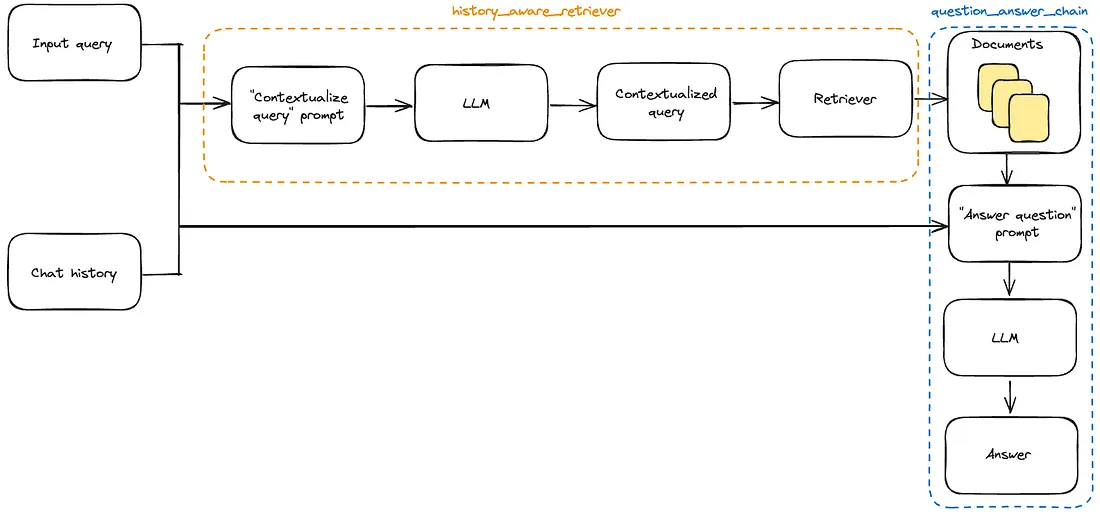

source: LangChain